<!-- ---
title: "Do winning decks in MTG World Championships have a particular card balance?"
author: "Paolo Saracco"
date: "2024-05-14"
output:
        bookdown::html_document2:
                fig_caption: true
                toc: true
                toc_depth: 2
                toc_float: 
                        collapsed: true
                number_sections: false
                keep_md: true
--- -->
# Do winning decks in MTG World Championships have a particular card balance?

author: Paolo Saracco

date: 2024-05-14

## Executive summary

*Magic: The Gathering* (aka MTG) is a well-known collectible card game created by Richard Garfield. The MTG World Championships (Worlds) is among the most important tournament in the game, offering cash prizes of up to $100,000 to the winners. We wonder whether winning decks in the standard format have a particular combination of different card types. To answer the question in the negative, we compare the number of Land, Creature, Instant and Sorcery, and Other card types in the top 4 decks of each World Championship from 1994 until 2022.

## Libraries

In [678]:
import requests
import re
from bs4 import BeautifulSoup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statistics import mean
import scipy.stats as ss
import os

## Data set

To collect the data we need, we scrape the webpage [www.mtgtop8.com](https://www.mtgtop8.com/) and we save the outcome in a csv file called `raw_magic.csv`.

In [679]:
folder = os.getcwd()
data_dir = Path(folder, "data")
Path(data_dir).mkdir(parents=True, exist_ok=True)
data_file = Path(data_dir, "raw_magic.csv")

if not data_file.exists() :
    print(f"{data_file} does not exists. Creating it...")

    players = pd.DataFrame(columns = ["Deck", "Player", "Format", "Event", "Level", "Rank", "Date"])
    decks = pd.DataFrame()

    for year in range(1994,2023,1) :
        # we skip year 2023 because there are decks with empty name field and
        # the command < data = row.text.strip().split("\n\t\t  ") >
        # produces a list which is shorter than the others,
        # running into the error
        # < ValueError: cannot set a row with mismatched columns >
        print(f"I am scraping year {year}")

        my_status = 200
        deck_rows = ["some rows..."]
        page = 1

        while my_status == 200 and deck_rows != [] :
            # gets the content of the page corresponding to
            # searching with the parameters given below
            url = "https://www.mtgtop8.com/"
            parameters = {"current_page" : f"{page}", 
                        "event_titre" : "world",
                        "format" : "ST",
                        "compet_check[P]" : "1",
                        "date_start" : f"01/01/{year}",
                        "date_end" : f"31/12/{year}"}
            response = requests.get(url + "search", params = parameters)
            my_status = response.status_code

            if my_status == 200 :

                soup = BeautifulSoup(response.text, "html5lib")

                deck_rows = soup.find_all("tr", class_ = "hover_tr")

                if deck_rows == [] :
                    print(f"Finished with year {year}. Moving to the next...")

                else :
                    # extract the table on the given page
                    # and concatenates it to the "players"
                    for row in deck_rows :
                        data = row.text.strip().split("\n\t\t  ")
                        players.loc[len(players)] = data

                    # extracts the links to the decks on the given page
                    deck_links = soup.find_all("a", href = re.compile(".*&d=.*"))

                    # for each link, it scrapes the info about the deck
                    # and concatenats it to the "decks"
                    deck_cards = []

                    for link in deck_links :
                        print(f"I am scraping year {year}, deck : {link.text}")
                        new_deck_url = url + link["href"]
                        response_new_deck = requests.get(new_deck_url)
                        soup_new_deck = BeautifulSoup(response_new_deck.text, "html5lib")
                        details_new_deck = soup_new_deck.find_all("div", class_ = "O14")
                        new_deck = {}
                        for elem in details_new_deck :
                            text_string = elem.text
                            text_string_list = text_string.split()
                            name = ""
                            value = 0
                            for text in text_string_list :
                                if text.isdigit() :
                                    value = int(text)
                                else :
                                    name = name + text + "_"
                            new_deck[f"{name.strip("_")}"] = value

                        deck_cards.append(pd.DataFrame(new_deck, index = [0]))
                
                    deck_cards = pd.concat(deck_cards, ignore_index=True)
                    decks = pd.concat([decks, deck_cards], ignore_index=True)

                    page += 1

            else :
                print(f"Status code page {page} or year {year} : {my_status}.")

    df = pd.concat([players,decks], axis=1)
    df.to_csv("data/raw_magic.csv", index=False)
    print("File created.")

else :
    print("File already existing. Scraping skipped.")

df = pd.read_csv(data_file)

File already existing. Scraping skipped.


## Data cleaning

In [680]:
df.head()

,Deck,Player,Format,Event,Level,Rank,Date,LANDS,CREATURES,INSTANTS_and_SORC.,OTHER_SPELLS,SIDEBOARD,LANDS_(29),LANDS_(26),LANDS_(27),LANDS_(28)
0,RG Aggro,Bertrand Lestrée,Standard,Worlds 1994 (Milwaukee) *,NaN,2,01/08/94,20.0,12.0,20.0,8.0,0.0,NaN,NaN,NaN,NaN
1,Wug Control,Zak Dolan,Standard,Worlds 1994 (Milwaukee) *,NaN,1,01/08/94,15.0,11.0,15.0,19.0,0.0,NaN,NaN,NaN,NaN
2,Zoo,Dominic Symens,Standard,Worlds 1994 (Milwaukee) *,NaN,3-4,01/08/94,16.0,12.0,19.0,13.0,0.0,NaN,NaN,NaN,NaN
3,Zoo,Cyrille de Foucaud,Standard,Worlds 1994 (Milwaukee) *,NaN,3-4,01/08/94,23.0,16.0,20.0,7.0,0.0,NaN,NaN,NaN,NaN
4,Rack Control,Alexander Blumke,Standard,Worlds 1995 (Seattle) *,NaN,1,01/08/95,25.0,6.0,18.0,14.0,0.0,NaN,NaN,NaN,NaN


In [681]:
data = df.copy()
data = data.drop(labels = ["Level","SIDEBOARD",'Format'], axis = 1)
data["Date"] = data["Date"].apply(lambda date : datetime.datetime.strptime(date, "%d/%m/%y"))
print("\n".join(data.Event.unique()))

Worlds 1994 (Milwaukee) *
Worlds 1995 (Seattle) *
Worlds 1996 (Seattle)
Worlds 1997 (Seattle) *
Worlds 1998 (Seattle)
Worlds 1999 (Yokohama)
Worlds 2000 (Brussels)
Worlds 2001 (Toronto)
Worlds 2002 (Sydney)
Worlds 2003 (Berlin)
Worlds 2004 (San Francisco)
Worlds 2005 (Yokohama)
Worlds 2006 (Paris)
Worlds 2007 (New York)
Worlds 2008 (Memphis)
Worlds 2009 (Rome)
Worlds 2010 (Chiba)
Worlds 2011 - Top 8
Worlds 2011 - Undefeated Standard
Worlds Standard (15 points and original)
2012 World Magic Cup
2013 World Championship
2014 World Magic Cup
2014 World Championship - Day 2
World Magic Cup 2015
2015 World Championship
2016 World Championship
2017 World Magic Cup
Worlds 2017
2018 World Magic Cup
Worlds 2018 (Las Vegas)
World Championship XXVI Honolulu
Magic World Championship XXVII (2021)
Magic World Championship XXVIII


First of all, we are only interested in the individual World Championship rankings. 

From [Wikipedia](https://en.wikipedia.org/w/index.php?title=Magic:_The_Gathering_World_Championship&oldid=1214619541):

*In 2012, the Magic World Championship structure was drastically altered alongside changes to the ranking system used in Magic: The Gathering. The individual World Championship was changed from a Pro Tour-sized event to a sixteen-player event, which was called the Magic Players Championship (though the tournament reverted to being called the World Championship for 2013). The team event, formerly held alongside the individual event, took place before the individual tournament and was contested by four-player teams instead of the previous three-player teams.*

*Team World Championship*
*The Team World Championship consists of three-player teams, with each team representing one country. Players that are eligible to play in the Team World Championship are the first, second and third place players at a country's National Championship.*

*World Magic Cup*
*In 2012, the Team World Championship became a single separate event called the 'World Magic Cup'. This national team event consists of four-player teams representing selected countries. The four players eligible to play in each national team will be the three winners of World Magic Cup qualifiers and the National Champion (the player finished with most Pro Points in previous season) of the country. The National Champion is the highest ranked player from that country in that year's rankings.* 

This means we do not consider the Pro Tours, including the 2012 Pro Tour that replaced the World Championship, and we drop the lines corresponding to the World Cups. 

Moreover, in 2011: *The eighteenth Magic World Championship was held from 17 to 20 November in the Fort Mason Center in San Francisco, the same site that already hosted the 2004 World Championship. The tournament consisted of six rounds of Standard on Thursday, two Innistrad Booster Drafts of three rounds each on Friday, and six rounds of Modern on Saturday. This would be the first World Championship to feature the new Modern format. On Sunday, the Top 8 players played against each other in elimination rounds, using the Standard decks they played on Thursday.*

We are only interested in the Top 8.

In [682]:
data = data[~data['Event'].str.contains('Cup')]
data = data[~data['Event'].str.contains('Undefeated')]
data = data[~data['Event'].str.contains('15 points')]
print("\n".join(data.Event.unique()))

Worlds 1994 (Milwaukee) *
Worlds 1995 (Seattle) *
Worlds 1996 (Seattle)
Worlds 1997 (Seattle) *
Worlds 1998 (Seattle)
Worlds 1999 (Yokohama)
Worlds 2000 (Brussels)
Worlds 2001 (Toronto)
Worlds 2002 (Sydney)
Worlds 2003 (Berlin)
Worlds 2004 (San Francisco)
Worlds 2005 (Yokohama)
Worlds 2006 (Paris)
Worlds 2007 (New York)
Worlds 2008 (Memphis)
Worlds 2009 (Rome)
Worlds 2010 (Chiba)
Worlds 2011 - Top 8
2013 World Championship
2014 World Championship - Day 2
2015 World Championship
2016 World Championship
Worlds 2017
Worlds 2018 (Las Vegas)
World Championship XXVI Honolulu
Magic World Championship XXVII (2021)
Magic World Championship XXVIII


Then we check how the rankings appear in the data.

In [683]:
print(data.Rank.unique())

['2' '1' '3-4' '5-8' 'Day 1 undefeated' 'Other' nan '9' '11' '10' '6' '16'
 '8' '12' '13' '7' '15' '14' '5' '4' '3' '17-32' '27' '20' '19' '31' '26'
 '17' '22' '24' '25' '28' '21' '18' '29' '32' '23']


By inspecting the Wikipedia page, we realise that in modern days it happens that the standard format is used only for the Top 4 on the last day:

*The 2016 World Championship was held from 1–4 September in Seattle. The formats used in the competition were Eldritch Moon-Shadows over Innistrad Booster Draft for rounds 1–3, Standard for rounds 4–7, Eldritch Moon-Shadows over Innistrad Booster Draft for rounds 8–10, Modern for rounds 11–14, and Standard for the Top 4.*

*The 2017 World Championship was held from 6–8 October in Boston. For the 2017 World Championship Wizards of the Coast decided to simplify the invitation criteria, awarding a large portion of invites to the players with the most Pro Points in the 2016–17 Pro Tour season. The formats used in the competition were Ixalan Booster Draft for rounds 1–3, Standard for rounds 4–7, Ixalan Booster Draft for rounds 8–10, Standard for rounds 11–14, and Standard for the Top 4.*

By Virtue of this observation, we select only the decks which are among the top 4 in every year, dropping everything else.

All the `Day 1 undefeated` ranked 9th or above:

In [684]:
print('Dates in which we have Day 1 undefeated rankings :')
for date in data[data['Rank'] == 'Day 1 undefeated'].Date.unique() :
    print(date.date())
    print('rankings : ' + str(data[data['Date'].dt.year == date.year].Rank.unique()))

Dates in which we have Day 1 undefeated rankings :
1997-08-17
rankings : ['1' '2' '3-4' '5-8' 'Day 1 undefeated']
1999-08-08
rankings : ['Day 1 undefeated' '5-8' 'Other' '3-4' '2' '1']
2001-08-12
rankings : ['1' '2' '3-4' '5-8' 'Day 1 undefeated']
2002-08-18
rankings : ['3-4' '5-8' '1' '2' 'Day 1 undefeated']
2003-08-10
rankings : ['1' '5-8' '3-4' '2' 'Day 1 undefeated']
2004-09-05
rankings : ['1' '2' '3-4' '5-8' 'Day 1 undefeated']
2005-12-04
rankings : ['1' '2' '3-4' '5-8' 'Day 1 undefeated']
2006-12-03
rankings : ['1' '2' '3-4' '5-8' 'Day 1 undefeated']
2007-12-06
rankings : ['Day 1 undefeated' nan '5-8' '1' '3-4' '2']
2008-12-14
rankings : ['5-8' '3-4' '2' '1' 'Day 1 undefeated']
2009-11-19
rankings : ['3-4' 'Day 1 undefeated' '2' '5-8' '1']
2010-12-12
rankings : ['2' '1' '5-8' '3-4' 'Day 1 undefeated' 'Other']


Since we are interested only in the top 4 ranked decks, we will drop these harmlessly. Concerning the `NaN`'s, instead:

In [685]:
print('Dates in which we have NaN rankings :')
for date in data[pd.isna(data['Rank'])].Date.unique() :
    print(date.date())
    print('rankings : ' + str(data[data['Date'].dt.year == date.year].Rank.unique()))

Dates in which we have NaN rankings :
2007-12-06
rankings : ['Day 1 undefeated' nan '5-8' '1' '3-4' '2']
2016-09-02
rankings : ['Other' '1' '2' nan '3-4']
2018-09-23
rankings : [nan '3-4' '1' '2']


All the NaN's ranked 5th or above, so we will drop them harmlessly. Concerning the `Other` rankings:

In [686]:
print('Dates in which we have Other rankings :')
for date in data[data['Rank'] == 'Other'].Date.unique() :
    print(date.date())
    print('rankings : ' + str(data[data['Date'].dt.year == date.year].Rank.unique()))

Dates in which we have Other rankings :
1999-08-08
rankings : ['Day 1 undefeated' '5-8' 'Other' '3-4' '2' '1']
2010-12-12
rankings : ['2' '1' '5-8' '3-4' 'Day 1 undefeated' 'Other']
2016-09-02
rankings : ['Other' '1' '2' nan '3-4']
2017-10-07
rankings : ['1' '2' '3-4' 'Other']


Again, all of them ranked 5th or above, so we will drop them harmlessly. 

Finally, the year 2014 has some issues: we correct it by checking the Wikipedia page by hands.

*The final standings were as follows:*
- *Israel Shahar Shenhar (2013 World Champion) - Decklist*
- *United States Patrick Chapin (Pro Tour Journey into Nyx winner)*
- *Japan Yuuya Watanabe (Pro Point leader Japan)*
- *Japan Kentaro Yamamoto (8th most Pro Points of otherwise unqualified)*

In [687]:
data.loc[data['Date'].dt.year == 2014,'Rank'] = np.NaN
data.loc[(data['Date'].dt.year == 2014) & (data['Player'] == 'Shahar Shenhar'),'Rank'] = '1'
data.loc[(data['Date'].dt.year == 2014) & (data['Player'] == 'Patrick Chapin'),'Rank'] = '2'
data.loc[(data['Date'].dt.year == 2014) & (data['Player'] == 'Yuuya Watanabe'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2014) & (data['Player'] == 'Kentaro Yamamoto'),'Rank'] = '4'

We can now proceed to select only the observations of interest:

In [688]:
data = data[data['Rank'].isin(['1', '2', '3', '4', '3-4'])]

One final issue comes from the fact that there are decks, from a certain moment on, in which there are cards with two faces, and one face is a land. Hence the scraped data contain in parenthesis the max number of lands the deck can count on, generating new columns. 

In [689]:
print(", ".join(data.columns))

Deck, Player, Event, Rank, Date, LANDS, CREATURES, INSTANTS_and_SORC., OTHER_SPELLS, LANDS_(29), LANDS_(26), LANDS_(27), LANDS_(28)


To begin with, I will try to consider them as non-lands.


In [690]:
lands_columns = [col for col in data.columns if "LANDS" in col]

for i in data.index :
    for col in lands_columns :
        if not pd.isna(data.loc[i,col]) : 
            data.loc[i,"Lands"] = data.loc[i,col]

data = data.drop(labels = lands_columns, axis = 1)
data = data.rename(columns = {"CREATURES" : "Creatures",
                          "INSTANTS_and_SORC." : "Instants_Sorceries", 
                          "OTHER_SPELLS" : "Other_spells"})

Commenting the previous Python script and uncommenting the underlying Python script will consider them as lands.

In [691]:
# for i in data.index :
#     if not pd.isna(data.loc[i,'LANDS_(26)']) :
#         data.loc[i,"Lands"] = 26
#     elif not pd.isna(data.loc[i,'LANDS_(27)']) :
#         data.loc[i,"Lands"] = 27
#     elif not pd.isna(data.loc[i,'LANDS_(28)']) :
#         data.loc[i,"Lands"] = 28
#     elif not pd.isna(data.loc[i,'LANDS_(29)']) :
#         data.loc[i,"Lands"] = 29
#     else :
#         data.loc[i,"Lands"] = data.loc[i,"LANDS"]

# lands_columns = [col for col in data.columns if "LANDS" in col]

# data = data.drop(labels = lands_columns, axis = 1)
# data = data.rename(columns = {"CREATURES" : "Creatures",
#                           "INSTANTS_and_SORC." : "Instants_Sorceries", 
#                           "OTHER_SPELLS" : "Other_spells"})

To proceed with the data cleaning phase, let us seek additional `NaN`'s.

In [692]:
pd.isna(data).sum(axis=0)

Deck                   0
Player                 0
Event                  0
Rank                   0
Date                   0
Creatures              8
Instants_Sorceries     1
Other_spells          18
Lands                  1
dtype: int64

Creatures, Lands and Other spells might not be an issue (see later), but Lands are:

In [693]:
data[np.isnan(data['Lands'])]

,Deck,Player,Event,Rank,Date,Creatures,Instants_Sorceries,Other_spells,Lands
10,(Red Artifact Control),Mark Justice,Worlds 1995 (Seattle) *,3-4,1995-08-01,NaN,NaN,60.0,NaN


Inspecting mtgtop8 reveals that the composition of this deck is unknown. We are forced to drop it.

In [694]:
data = data[~np.isnan(data['Lands'])]
pd.isna(data).sum(axis=0)

Deck                   0
Player                 0
Event                  0
Rank                   0
Date                   0
Creatures              7
Instants_Sorceries     0
Other_spells          18
Lands                  0
dtype: int64

In all the other cases, the NaN value shall be a 0:

In [695]:
data[pd.isna(data['Creatures'])]

,Deck,Player,Event,Rank,Date,Creatures,Instants_Sorceries,Other_spells,Lands
5,WR Control,Marc Hernandez,Worlds 1995 (Seattle) *,2,1995-08-01,NaN,15.0,27.0,20.0
76,Wake,Daniel Zink,Worlds 2003 (Berlin),1,2003-08-10,NaN,26.0,7.0,27.0
82,Wake,Tuomo Nieminen,Worlds 2003 (Berlin),3-4,2003-08-10,NaN,25.0,9.0,26.0
83,Wake,Jin Okamoto,Worlds 2003 (Berlin),2,2003-08-10,NaN,27.0,7.0,26.0
90,KCI,Manuel Bevand,Worlds 2004 (San Francisco),3-4,2004-09-05,NaN,18.0,23.0,19.0
102,Enduring Ideal,Akira Asahara,Worlds 2005 (Yokohama),3-4,2005-12-04,NaN,17.0,20.0,23.0
514,Izzet Control,Ondřej Stráský,Magic World Championship XXVII (2021),4,2021-10-05,NaN,37.0,NaN,23.0


In [696]:
data[pd.isna(data['Other_spells'])]

,Deck,Player,Event,Rank,Date,Creatures,Instants_Sorceries,Other_spells,Lands
20,Black Five,Jakub Slemr,Worlds 1997 (Seattle) *,1,1997-08-17,25.0,14.0,NaN,22.0
21,URw Aggro,Janosch Kuhn,Worlds 1997 (Seattle) *,2,1997-08-17,8.0,30.0,NaN,22.0
49,Ice Age.dec,Dominik Hothow,Worlds 2000 (Brussels),3-4,2000-08-06,25.0,11.0,NaN,24.0
57,Machinehead,Tom Van de Logt,Worlds 2001 (Toronto),1,2001-08-12,18.0,18.0,NaN,24.0
67,Psychatog,Diego Ostrovich,Worlds 2002 (Sydney),3-4,2002-08-18,8.0,28.0,NaN,24.0
71,Psychatog,Carlos Romão,Worlds 2002 (Sydney),1,2002-08-18,8.0,28.0,NaN,24.0
72,Psychatog,Dave Humpherys,Worlds 2002 (Sydney),3-4,2002-08-18,9.0,26.0,NaN,25.0
73,BurningTog,Mark Ziegner,Worlds 2002 (Sydney),2,2002-08-18,13.0,23.0,NaN,24.0
78,UG Madness,David Humpherys,Worlds 2003 (Berlin),3-4,2003-08-10,18.0,20.0,NaN,22.0
89,Goblins,Ryou Ogura,Worlds 2004 (San Francisco),3-4,2004-09-05,33.0,4.0,NaN,23.0


In [697]:
data = data.fillna(0)

To conclude, we need to adjust the rankings:

In [698]:
data.value_counts(subset = ["Rank"])

Rank
3-4     43
1       27
2       27
3        5
4        5
Name: count, dtype: int64

We have 43 `3-4` rankings. we add them by hands checking on [Wikipedia 13/05/2024](https://en.wikipedia.org/w/index.php?title=Magic:_The_Gathering_World_Championship&oldid=1214619541) (and we also correct two typos in the player names).

In [699]:
data.loc[(data['Date'].dt.year == 1994) & (data['Player'] == 'Dominic Symens'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1994) & (data['Player'] == 'Cyrille de Foucaud'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 1995) & (data['Player'] == 'Henry Stern'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1996) & (data['Player'] == 'Henry Stern'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1996) & (data['Player'] == 'Olle Råde'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 1997) & (data['Player'] == 'Paul McCabe'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1997) & (data['Player'] == 'Svend Sparre Geertsen'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 1998) & (data['Player'] == 'Jon Finkel'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1998) & (data['Player'] == 'Raphael Levy'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 1999) & (data['Player'] == 'Raffaele Lo Moro'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 1999) & (data['Player'] == 'Matt Linde'),'Rank'] = '4'

data.loc[(data['Date'].dt.year == 2000) & (data['Player'] == 'Dominik Hothow'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2000) & (data['Player'] == 'Benedikt Klauser'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2001) & (data['Player'] == 'Antoine Ruel'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2001) & (data['Player'] == 'Andrea Santin'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2002) & (data['Player'] == 'Diego Ostrovich'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2002) & (data['Player'] == 'Dave Humpherys'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2003) & (data['Player'] == 'Tuomo Nieminen'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2003) & (data['Player'] == 'David Humpherys'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2004) & (data['Player'] == 'Ryou Ogura'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2004) & (data['Player'] == 'Manuel Bevand'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2005) & (data['Player'] == 'Tomohiro Kaji'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2005) & (data['Player'] == 'Akira Asahara'),'Rank'] = '4'

data.loc[(data['Date'].dt.year == 2006) & (data['Player'] == 'Nicholas Lovett'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2006) & (data['Player'] == 'Gabriel Nassif'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2007) & (data['Player'] == 'Gabriel Nassif'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2007) & (data['Player'] == 'Kotaro Otsuka'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2008) & (data['Player'] == 'Tsuyoshi Ikeda'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2008) & (data['Player'] == 'Hannes Kerem'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2009) & (data['Player'] == 'Terry Soh'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2009) & (data['Player'] == 'Bram Snepvangers'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2010) & (data['Player'] == 'Paulo Vitor Damo da Rosa'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2010) & (data['Player'] == 'Love Janse'),'Rank'] = '4'

data.loc[(data['Date'].dt.year == 2011) & (data['Player'] == 'Conley Woods'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2011) & (data['Player'] == 'David Caplan'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2013) & (data['Player'] == 'Ben Stark'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2013) & (data['Player'] == 'Josh Utter-Leyton'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2016) & (data['Player'] == 'Oliver Tiu'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2016) & (data['Player'] == 'Shota Yasooka'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2017) & (data['Player'] == 'Josh Utter-leyton'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2017) & (data['Player'] == 'Kelvin Chew'),'Rank'] = '4'
data.loc[(data['Date'].dt.year == 2018) & (data['Player'] == 'Benjamin Stark'),'Rank'] = '3'
data.loc[(data['Date'].dt.year == 2018) & (data['Player'] == 'Shahar Shenhar'),'Rank'] = '4'

data.loc[(data['Date'].dt.year == 2013) & (data['Player'] == 'Ben Stark'),'Player'] = 'Benjamin Stark'
data.loc[(data['Date'].dt.year == 2017) & (data['Player'] == 'Josh Utter-leyton'),'Player'] = 'Josh Utter-Leyton'

data['Rank'] = data['Rank'].astype('category')
data.value_counts(subset = ["Rank"])

Rank
1       27
2       27
3       27
4       26
Name: count, dtype: int64

We can now work with our cleaned data set:

In [700]:
data.to_csv("data/magic.csv", index=False)

folder = os.getcwd()
cleaned_data = Path(folder, "data", "magic.csv")
data = pd.read_csv(cleaned_data)

data["Date"] = data["Date"].apply(lambda date : datetime.datetime.strptime(date, "%Y-%m-%d"))
data['Rank'] = data['Rank'].astype('category')

## Exploratory data analysis

In [701]:
data.head()

,Deck,Player,Event,Rank,Date,Creatures,Instants_Sorceries,Other_spells,Lands
0,RG Aggro,Bertrand Lestrée,Worlds 1994 (Milwaukee) *,2,1994-08-01,12.0,20.0,8.0,20.0
1,Wug Control,Zak Dolan,Worlds 1994 (Milwaukee) *,1,1994-08-01,11.0,15.0,19.0,15.0
2,Zoo,Dominic Symens,Worlds 1994 (Milwaukee) *,3,1994-08-01,12.0,19.0,13.0,16.0
3,Zoo,Cyrille de Foucaud,Worlds 1994 (Milwaukee) *,4,1994-08-01,16.0,20.0,7.0,23.0
4,Rack Control,Alexander Blumke,Worlds 1995 (Seattle) *,1,1995-08-01,6.0,18.0,14.0,25.0


In [702]:
data.describe()

,Date,Creatures,Instants_Sorceries,Other_spells,Lands
count,107,107.000000,107.000000,107.000000,107.000000
mean,2008-04-10 00:53:49.906542080,15.355140,15.084112,6.242991,23.485981
min,1994-08-01 00:00:00,0.000000,2.000000,0.000000,15.000000
25%,2001-02-07 12:00:00,9.000000,9.000000,2.000000,22.000000
50%,2007-12-06 00:00:00,16.000000,15.000000,4.000000,24.000000
75%,2015-08-30 00:00:00,22.500000,19.500000,8.000000,25.000000
max,2022-10-28 00:00:00,33.000000,37.000000,28.000000,28.000000
std,NaN,8.427552,7.817640,6.032680,2.400332


A first interesting question is to see the evolution of the composition of decks along time.

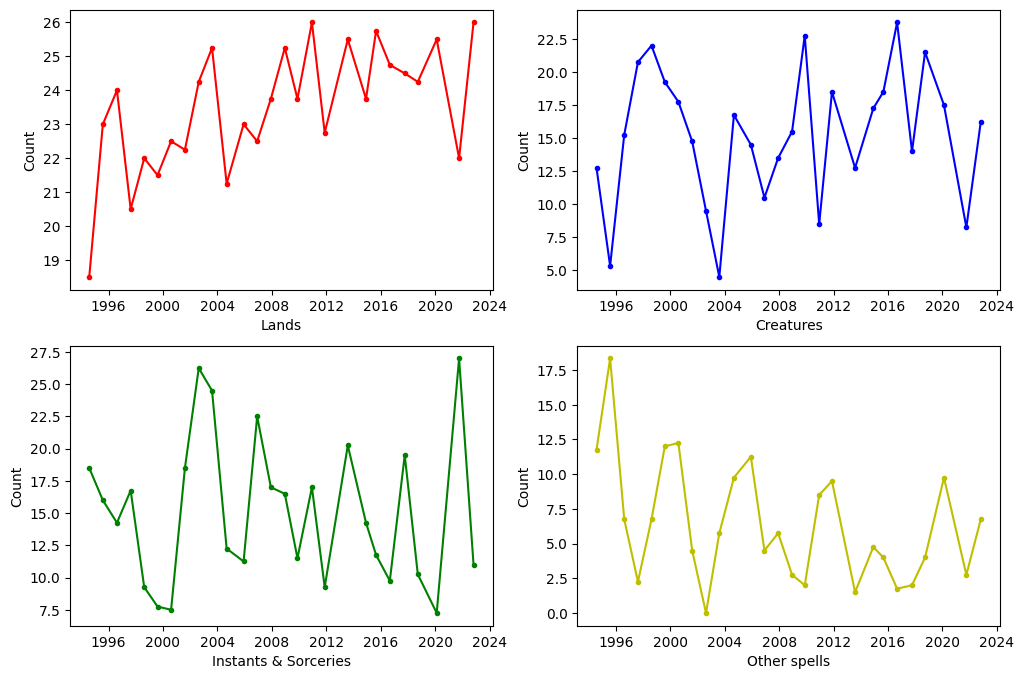

In [703]:
data_mean_byYear = data[['Date','Creatures','Instants_Sorceries','Other_spells','Lands']].groupby('Date', observed=False).mean()
figure, axis = plt.subplots(2, 2, figsize=(12,8)) 

axis[0,0].plot(data_mean_byYear["Lands"], 'r.-', label='Lands')
axis[0,0].set(xlabel='Lands',ylabel='Count')
axis[0,1].plot(data_mean_byYear["Creatures"], 'b.-', label='Creatures')
axis[0,1].set(xlabel='Creatures',ylabel='Count')
axis[1,0].plot(data_mean_byYear["Instants_Sorceries"], 'g.-', label='Instants & Sorceries')
axis[1,0].set(xlabel='Instants & Sorceries',ylabel='Count')
axis[1,1].plot(data_mean_byYear["Other_spells"], 'y.-', label='Other spells')
axis[1,1].set(xlabel='Other spells',ylabel='Count')

plt.show()

Another interesting question is to see the evolution of the composition of the top ranked decks over time.

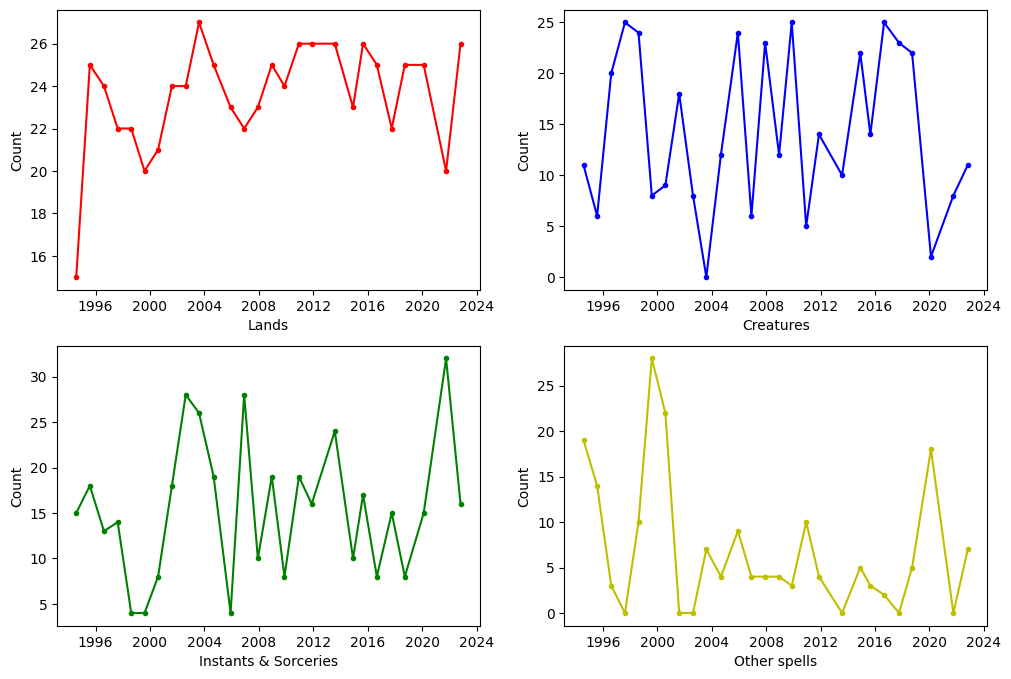

In [704]:
Champs = data[data["Rank"] == 1]
Champs = Champs.reset_index().drop(['index','Rank'], axis=1)

figure, axis = plt.subplots(2, 2, figsize=(12,8)) 

axis[0,0].plot(Champs["Date"], Champs["Lands"], 'r.-', label='Lands')
axis[0,0].set(xlabel='Lands',ylabel='Count')
axis[0,1].plot(Champs["Date"], Champs["Creatures"], 'b.-', label='Creatures')
axis[0,1].set(xlabel='Creatures',ylabel='Count')
axis[1,0].plot(Champs["Date"], Champs["Instants_Sorceries"], 'g.-', label='Instants & Sorceries')
axis[1,0].set(xlabel='Instants & Sorceries',ylabel='Count')
axis[1,1].plot(Champs["Date"], Champs["Other_spells"], 'y.-', label='Other spells')
axis[1,1].set(xlabel='Other spells',ylabel='Count')

plt.show()

The surprising value of 15 Lands in the first winnign deck can be explained by the fact that it was playing Moxes, artifacts (hence, Other spells) which provide one mana of a certain color. We also observe two peaks in the Other spells count in years 2000 and 2020. 2000 was the year of the Tinker deck - mainly based on the Sorcery 'Tinker' and a great amount of artifacts.

Then we use violin plots to visualise the distribution of the four groups.

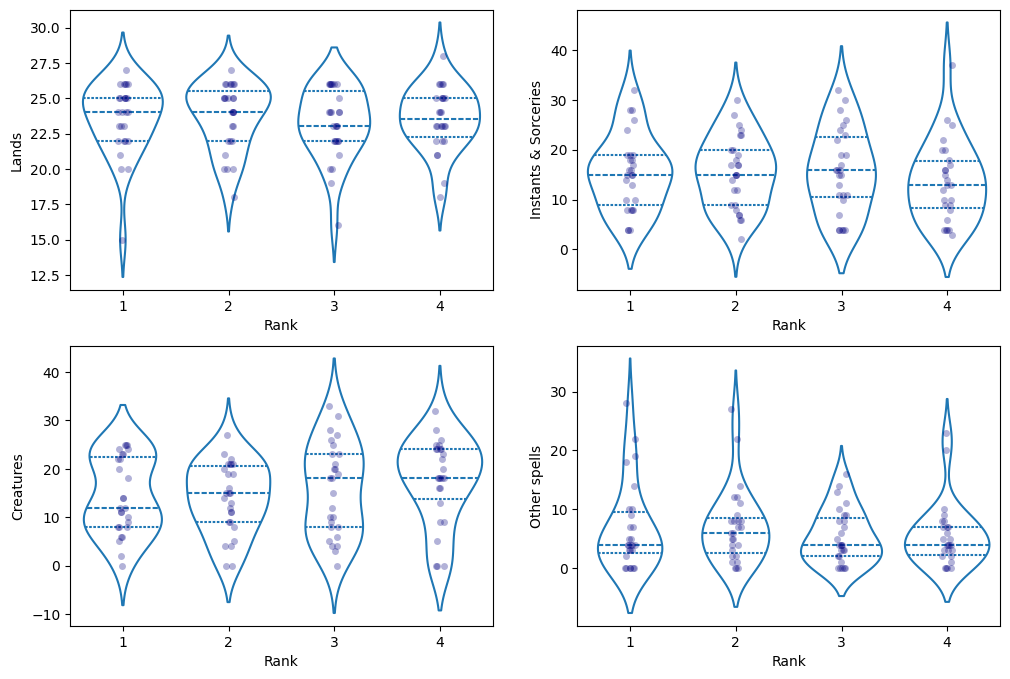

In [705]:
figure, axis = plt.subplots(2, 2, figsize=(12,8)) 

sns.violinplot(x='Rank', y='Lands', data=data, fill=False, inner='quart', ax=axis[0,0])
sns.stripplot(x='Rank', y='Lands', data=data, alpha=0.3, color='navy', jitter=0.05, ax=axis[0,0])
axis[0,0].set(xlabel='Rank',ylabel='Lands')
sns.violinplot(x='Rank', y='Creatures', data=data, fill=False, inner='quart', ax=axis[1,0])
sns.stripplot(x='Rank', y='Creatures', data=data, alpha=0.3, color='navy', jitter=0.05, ax=axis[1,0])
axis[1,0].set(xlabel='Rank',ylabel='Creatures')
sns.violinplot(x='Rank', y='Instants_Sorceries', data=data, fill=False, inner='quart', ax=axis[0,1])
sns.stripplot(x='Rank', y='Instants_Sorceries', data=data, alpha=0.3, color='navy', jitter=0.05, ax=axis[0,1])
axis[0,1].set(xlabel='Rank',ylabel='Instants & Sorceries')
sns.violinplot(x='Rank', y='Other_spells', data=data, fill=False, inner='quart', ax=axis[1,1])
sns.stripplot(x='Rank', y='Other_spells', data=data, alpha=0.3, color='navy', jitter=0.05, ax=axis[1,1])
axis[1,1].set(xlabel='Rank',ylabel='Other spells')

plt.show()

Apparently, there is no difference, on average, in the composition of the decks. A box plot can confirm this claim, by also giving a more reasonable output (we cannot expect a negative number of cards in a deck).

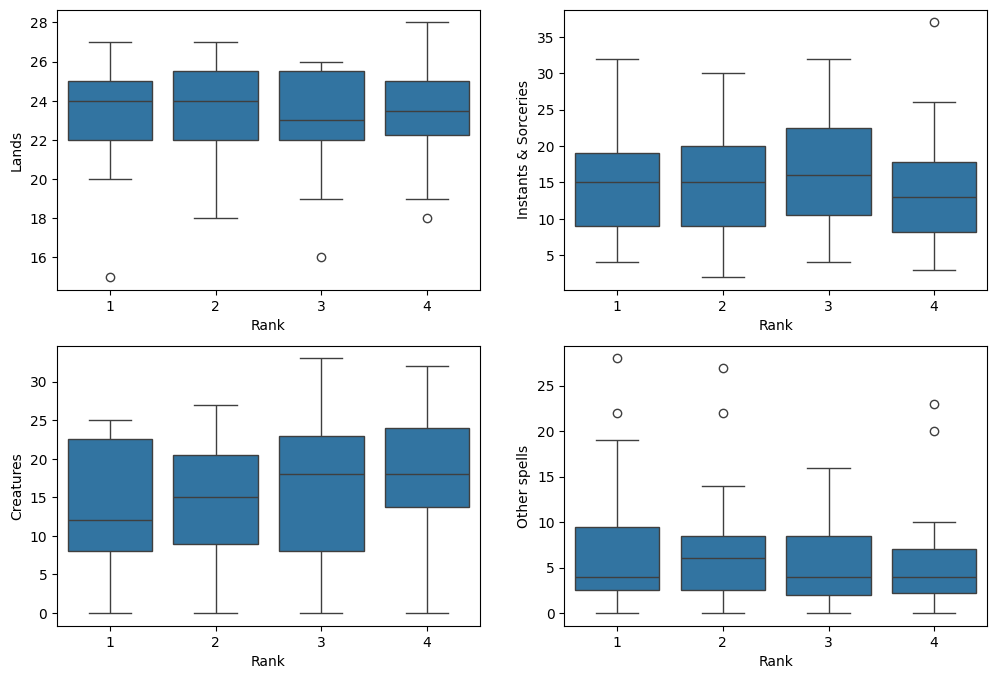

In [706]:
figure, axis = plt.subplots(2, 2, figsize=(12,8)) 

sns.boxplot(x='Rank', y='Lands', data=data, ax=axis[0,0])
axis[0,0].set(xlabel='Rank',ylabel='Lands')
sns.boxplot(x='Rank', y='Creatures', data=data, ax=axis[1,0])
axis[1,0].set(xlabel='Rank',ylabel='Creatures')
sns.boxplot(x='Rank', y='Instants_Sorceries', data=data, ax=axis[0,1])
axis[0,1].set(xlabel='Rank',ylabel='Instants & Sorceries')
sns.boxplot(x='Rank', y='Other_spells', data=data, ax=axis[1,1])
axis[1,1].set(xlabel='Rank',ylabel='Other spells')

plt.show()

## Statistical tests for equality of the means

To begin with, we want to determine whether there is a statistically significant difference between the number of Lands in decks that ranked first, second, third or fourth, on average.

We have two ways to perform this. The first one is to divide the data on the number of Lands into four groups corresponding to the four rankings and pass them to an **ANOVA test**. In its simplest form, ANOVA provides a statistical test of whether two or more population means are equal, and therefore generalizes the t-test beyond two means. In other words, the ANOVA is used to test the difference between two or more means.

However, the analysis of variance can be presented in terms of a linear model, which makes the following assumptions about the probability distribution of the responses:

- Independence of observations : this is an assumption of the model that simplifies the statistical analysis.
- Normality : the distributions of the residuals are normal. In our case, the distribution of the data in each group.
- Equality (or "homogeneity") of variances, called homoscedasticity : the variance of data in groups should be the same.

The second way is to repeatedly use **Welch's t-test**, which allows to compare means of populations with different variances, but the assumption of normality is maintained.

In each case, we need to divide the data of interest into 4 different groups according to the ranking. Let us perform this.

In [707]:
Lands_groups = []
for i in range(4) :
    Lands_groups.append(data[data['Rank'] == (i+1)]['Lands'])

Creature_groups = []
for i in range(4) :
    Creature_groups.append(data[data['Rank'] == (i+1)]['Creatures'])

IandS_groups = []
for i in range(4) :
    IandS_groups.append(data[data['Rank'] == (i+1)]['Instants_Sorceries'])

Others_groups = []
for i in range(4) :
    Others_groups.append(data[data['Rank'] == (i+1)]['Other_spells'])

Then let us check the homoscedasticity assumption by printing a table of variances:

In [708]:
data[['Rank','Creatures','Instants_Sorceries','Other_spells','Lands']].groupby('Rank',observed=False).apply(np.var, (0))

,Creatures,Instants_Sorceries,Other_spells,Lands
Rank,,,,
1,60.222222,55.945130,52.644719,6.320988
2,51.283951,50.320988,39.283951,5.319616
3,86.320988,69.135802,20.463649,6.052126
4,76.019231,64.226331,29.321006,4.940828


Therefore we cannot rely on homoscedasticity, but we may still perform the ANOVA test, for the sake of seeing the outcomes.

In [709]:
long_data = pd.melt(frame=data,
                    id_vars=['Deck','Player','Event','Rank','Date'],
                    value_vars=['Creatures','Instants_Sorceries','Other_spells','Lands'],
                    var_name='Type',
                    value_name='Count')

for name_group in long_data.groupby('Type',observed=False):
    samples = [condition[1] for condition in name_group[1].groupby('Rank',observed=False)['Count']]
    f_val, p_val = ss.f_oneway(*samples)
    print(f'Type: {name_group[0]},\nF value: {f_val:.3f},\np value: {p_val:.3f}\n')

Type: Creatures,
F value: 0.988,
p value: 0.401

Type: Instants_Sorceries,
F value: 0.389,
p value: 0.761

Type: Lands,
F value: 0.258,
p value: 0.855

Type: Other_spells,
F value: 0.549,
p value: 0.650



Thus, apparently, there is no significant difference. We could apply a t-test to confirm the conclusion, but there is an additional issue to address: in general, data are not normally distributed.

In [710]:
for name_group in long_data.groupby(by=['Type','Rank'], observed=False):
    samples = [condition for condition in name_group[1]['Count']]
    w_val, p_val = ss.shapiro(samples)
    print(f'Type: {name_group[0][0]},\nRank: {name_group[0][1]}\nW value: {w_val:.3f},\np value: {p_val:.3f}\n')

Type: Creatures,
Rank: 1
W value: 0.916,
p value: 0.031

Type: Creatures,
Rank: 2
W value: 0.960,
p value: 0.372

Type: Creatures,
Rank: 3
W value: 0.956,
p value: 0.295

Type: Creatures,
Rank: 4
W value: 0.911,
p value: 0.028

Type: Instants_Sorceries,
Rank: 1
W value: 0.953,
p value: 0.256

Type: Instants_Sorceries,
Rank: 2
W value: 0.977,
p value: 0.799

Type: Instants_Sorceries,
Rank: 3
W value: 0.948,
p value: 0.196

Type: Instants_Sorceries,
Rank: 4
W value: 0.934,
p value: 0.097

Type: Lands,
Rank: 1
W value: 0.874,
p value: 0.004

Type: Lands,
Rank: 2
W value: 0.908,
p value: 0.020

Type: Lands,
Rank: 3
W value: 0.905,
p value: 0.017

Type: Lands,
Rank: 4
W value: 0.957,
p value: 0.344

Type: Other_spells,
Rank: 1
W value: 0.824,
p value: 0.000

Type: Other_spells,
Rank: 2
W value: 0.860,
p value: 0.002

Type: Other_spells,
Rank: 3
W value: 0.922,
p value: 0.044

Type: Other_spells,
Rank: 4
W value: 0.797,
p value: 0.000



The following frequency plot confirms what we already observed.

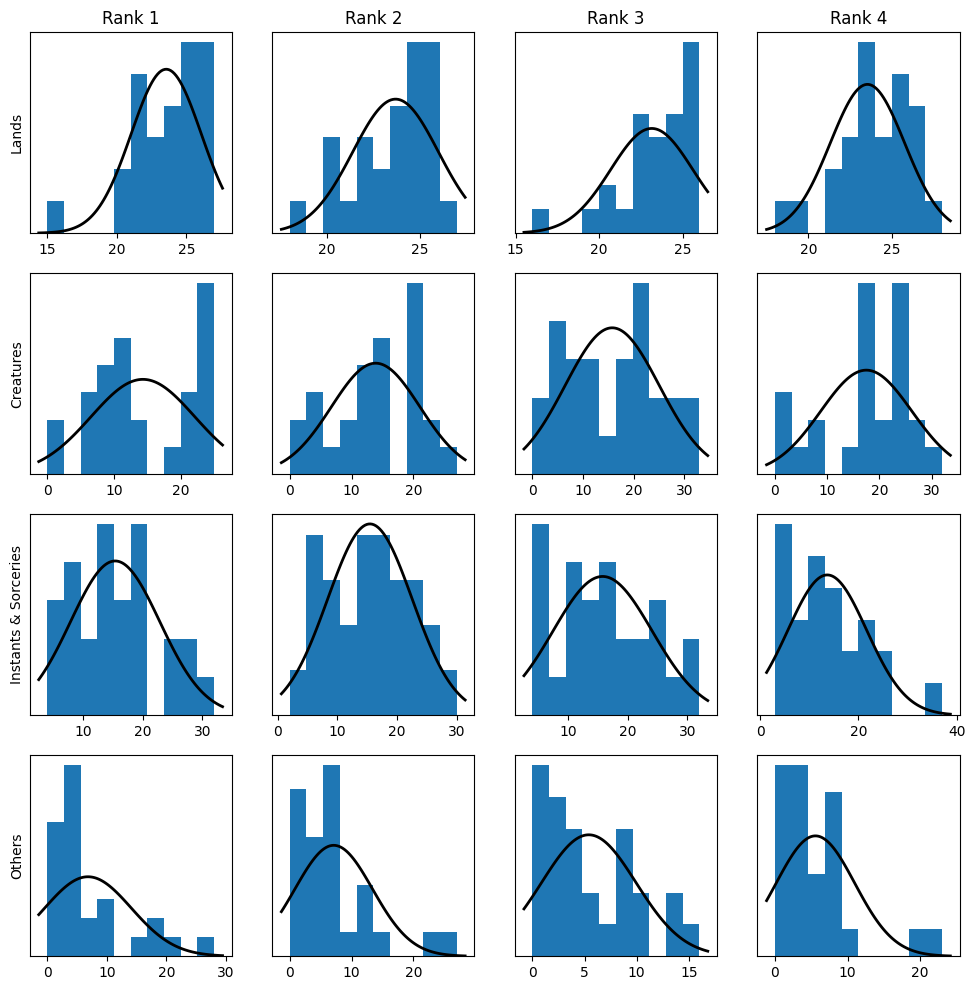

In [711]:
figure, axis = plt.subplots(4,4, figsize=(12,12)) 

for i,group in enumerate([Lands_groups,Creature_groups,IandS_groups,Others_groups]) :
    for j in range(4) :
        axis[i,j].hist(group[j], density=True)
        mu, std = ss.norm.fit(group[j]) 
        xmin, xmax = axis[i,j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = ss.norm.pdf(x, mu, std)
        axis[i,j].plot(x, p, 'k', linewidth=2)
        axis[i,j].get_yaxis().set_ticks([])

axis[0,0].set(ylabel='Lands', title='Rank 1')
axis[0,1].set(title='Rank 2')
axis[0,2].set(title='Rank 3')
axis[0,3].set(title='Rank 4')
axis[1,0].set(ylabel='Creatures')
axis[2,0].set(ylabel='Instants & Sorceries')
axis[3,0].set(ylabel='Others')

plt.show()

This might be due to a low number of observations or to a trend we cannot identify at present. Nevertheless, we expect our data to be normally distributed (possibly with unequal variances) and thus we apply Welch's t-test as discussed.

In [712]:
for i,group in enumerate([Creature_groups,IandS_groups,Others_groups,Lands_groups]) :
    for j in range(4) :
        if i != j :
            t_val, p_val = ss.ttest_ind(group[i], group[j], equal_var = False)
            print(f'Type : {data.columns[i+5]}\nRank {i+1} vs Rank {j+1}\nT statistic : {t_val:.3f}\np value : {p_val:.3f}\n')

Type : Creatures
Rank 1 vs Rank 2
T statistic : 0.215
p value : 0.831

Type : Creatures
Rank 1 vs Rank 3
T statistic : -0.608
p value : 0.546

Type : Creatures
Rank 1 vs Rank 4
T statistic : -1.368
p value : 0.177

Type : Instants_Sorceries
Rank 2 vs Rank 1
T statistic : 0.018
p value : 0.985

Type : Instants_Sorceries
Rank 2 vs Rank 3
T statistic : -0.156
p value : 0.877

Type : Instants_Sorceries
Rank 2 vs Rank 4
T statistic : 0.844
p value : 0.403

Type : Other_spells
Rank 3 vs Rank 1
T statistic : -0.861
p value : 0.394

Type : Other_spells
Rank 3 vs Rank 2
T statistic : -1.124
p value : 0.267

Type : Other_spells
Rank 3 vs Rank 4
T statistic : -0.121
p value : 0.904

Type : Lands
Rank 4 vs Rank 1
T statistic : -0.026
p value : 0.980

Type : Lands
Rank 4 vs Rank 2
T statistic : -0.261
p value : 0.795

Type : Lands
Rank 4 vs Rank 3
T statistic : 0.595
p value : 0.555



## Conclusions

We conclude that there is no statistically significant difference at level alpha = 0.05 in the composition of the decks. The conclusion does not change if we consider the double-faced cards Land/non-Land as Lands. A further analysis may take into account colors or frequency of single cards in a deck.

## Appendix

It could be interesting to see how the number of Lands, Creatures, Instants & Sorceries, and Other spells evolved in time for all rankings (and not just the top one).

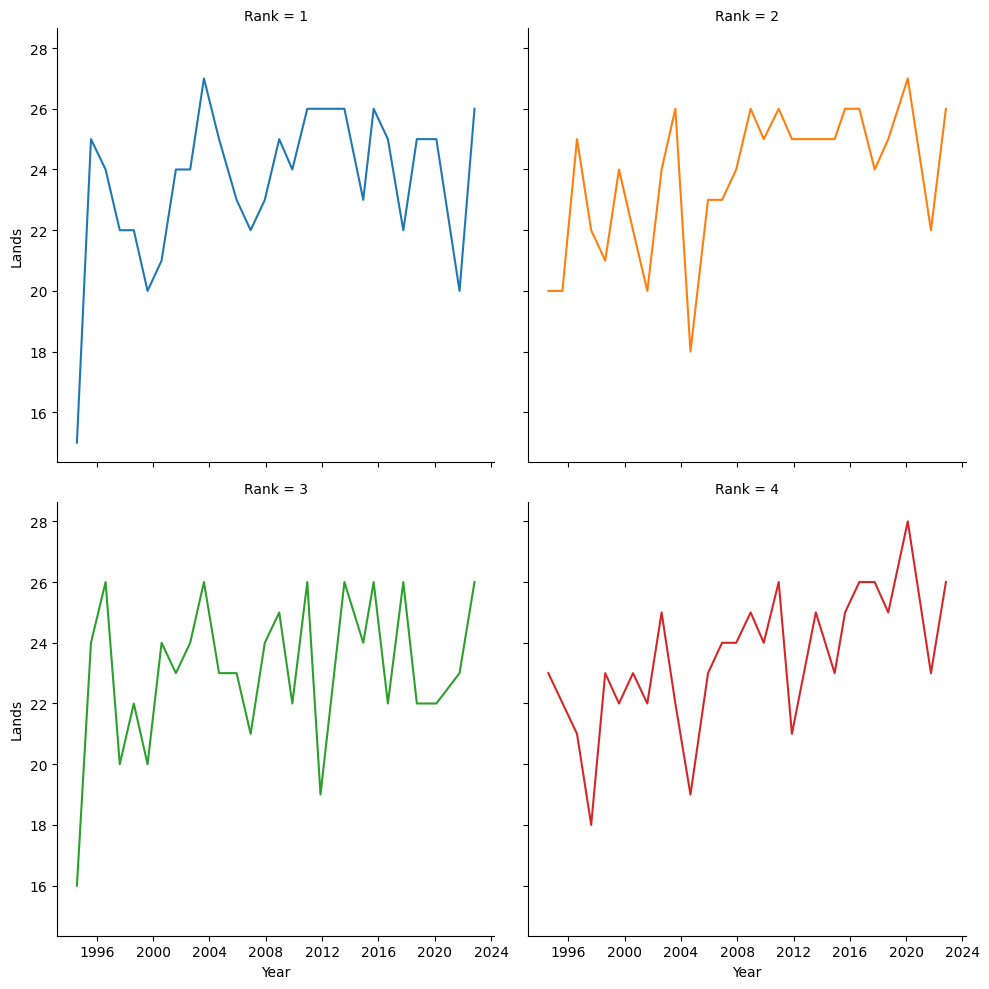

In [713]:
g = sns.relplot(kind='line', 
                data=data, 
                x='Date', 
                y='Lands', 
                hue='Rank', 
                col='Rank', 
                col_wrap=2, 
                legend = False).set_axis_labels("Year", "Lands")

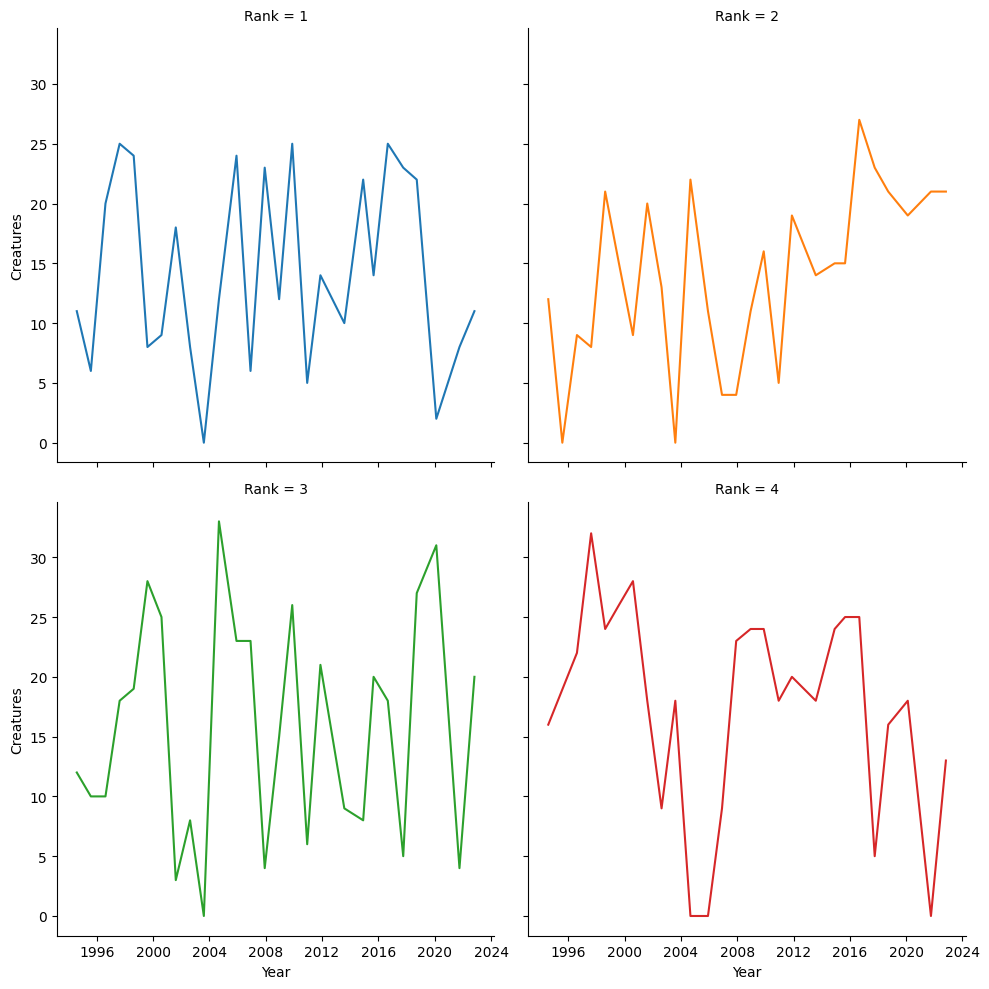

In [714]:
g = sns.relplot(kind='line', 
                data=data, 
                x='Date', 
                y='Creatures', 
                hue='Rank', 
                col='Rank', 
                col_wrap=2, 
                legend = False).set_axis_labels("Year", "Creatures")

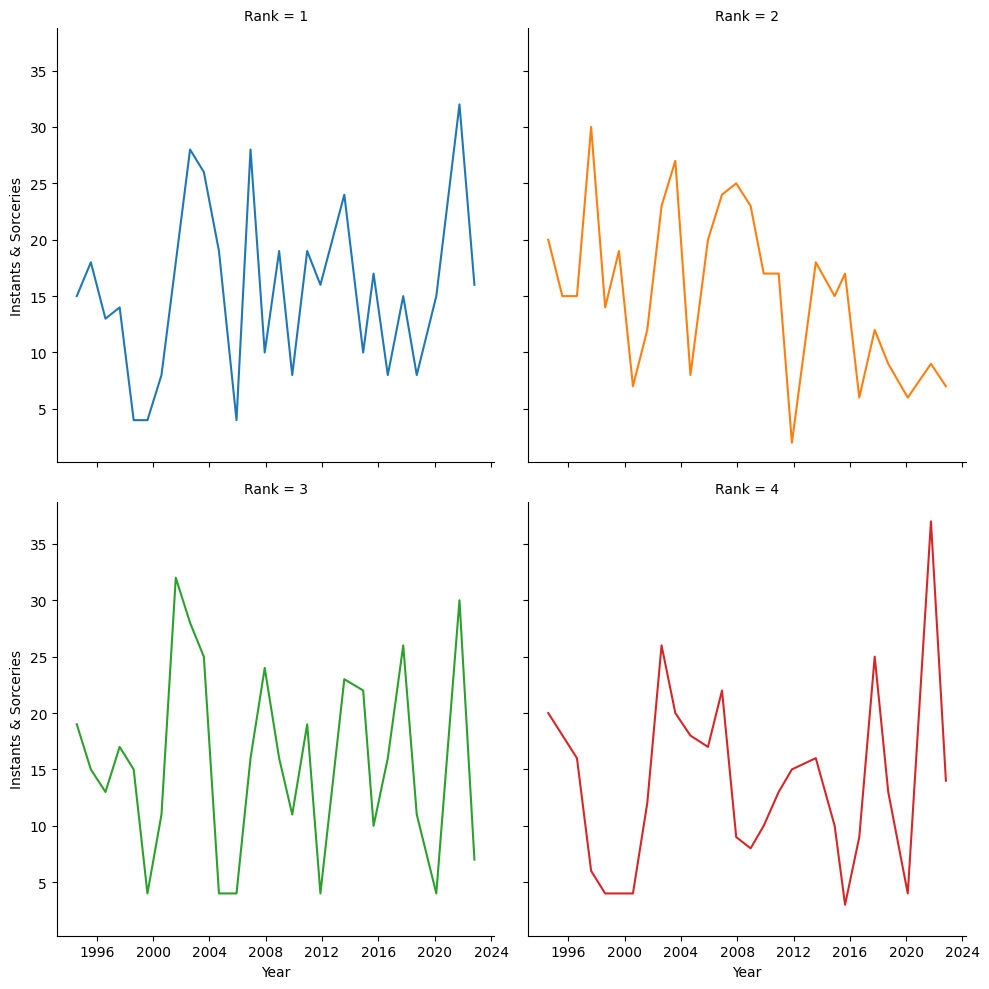

In [715]:
g = sns.relplot(kind='line', 
                data=data, 
                x='Date', 
                y='Instants_Sorceries', 
                hue='Rank', 
                col='Rank', 
                col_wrap=2, 
                legend = False).set_axis_labels("Year", "Instants & Sorceries")

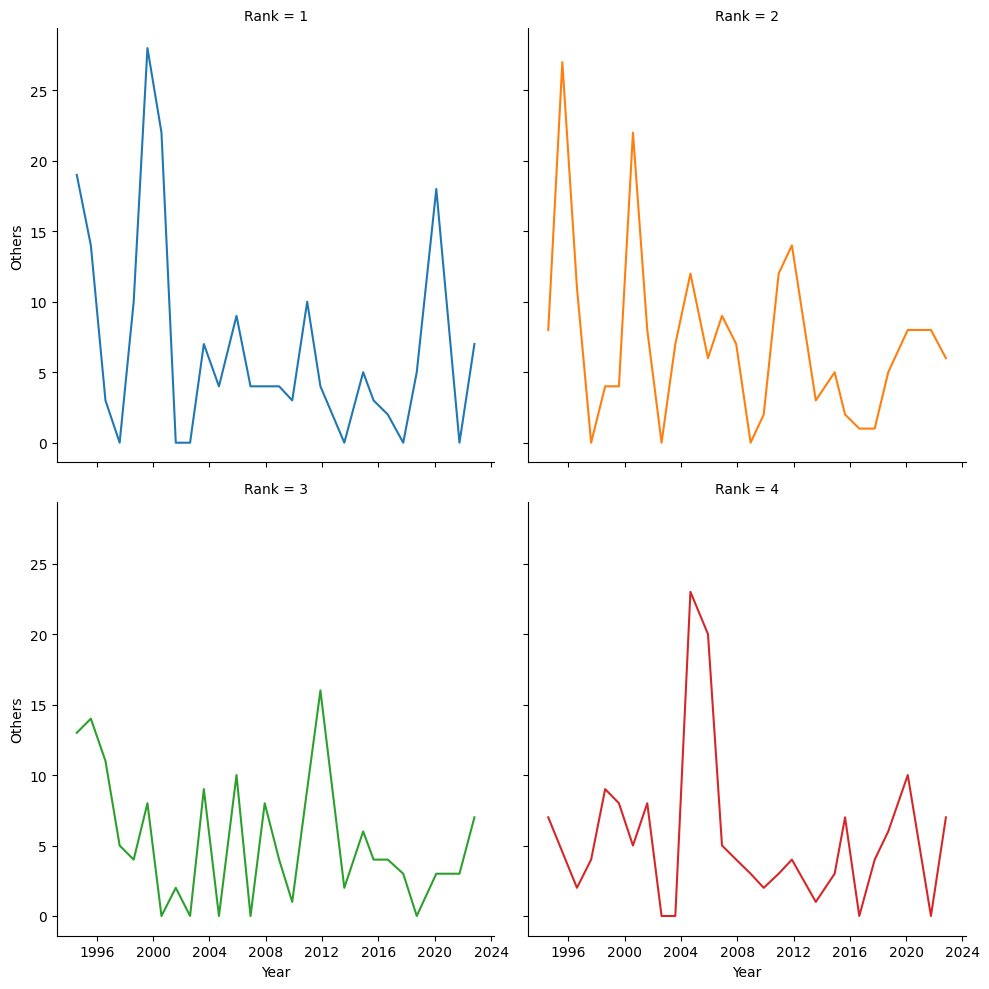

In [716]:
g = sns.relplot(kind='line', 
                data=data, 
                x='Date', 
                y='Other_spells', 
                hue='Rank', 
                col='Rank', 
                col_wrap=2, 
                legend = False).set_axis_labels("Year", "Others")